In [124]:
import torch
import torch.nn as nn
import os
from torchvision import transforms
from PIL import Image
import numpy as np
from torchvision.models.feature_extraction import create_feature_extractor
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

use_cuda = torch.cuda.is_available()

print(use_cuda)
if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

DEVICE = torch.device("cuda:2" if use_cuda else "cpu")

True
__CUDNN VERSION: 90100
__Number CUDA Devices: 3
__CUDA Device Name: NVIDIA RTX A5500
__CUDA Device Total Memory [GB]: 25.418268672


In [125]:


def load_image(img_path):
    image = Image.open(img_path).convert('RGB')
    print(type(image))
    img_transform = transforms.Compose([
        transforms.Resize((512, 512)),  # Resize the image to 256x256
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    return img_transform(image).unsqueeze(0)

# Function to convert a tensor back to an image
def im_convert(tensor):
    image = tensor.clone().detach().cpu().squeeze(0)
    image = image.numpy().transpose(1, 2, 0)
    # Un-normalize the image
    image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    image = image.clip(0, 1)
    return image

In [126]:
# Definition of the Vgg19 model and extraction of feature map we want to see 
with torch.no_grad():
    vgg_net = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19_bn', pretrained=True);
    vgg_net.eval().to(DEVICE);

style_feature_extractor = create_feature_extractor(vgg_net,{'features.0':'conv1', 'features.5':'conv2', 'features.10':'conv3', 'features.19':'conv4', 'features.28':'conv5'})

content_feature_extractor = create_feature_extractor(vgg_net,{'features.28':'conv5'})


Using cache found in /home/rotakagui/.cache/torch/hub/pytorch_vision_v0.10.0
/home/rotakagui/miniconda3/envs/jupy/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rotakagui/miniconda3/envs/jupy/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [127]:
# Load images

project_dir = '/home/rotakagui/projects/pytorch-neural-style-transfer'
content_img_path = os.path.join(project_dir, 'data', 'content', 'bariloche.jpg')
style_img_path   = os.path.join(project_dir, 'data', 'style', 'shipwreck.jpg')

content_img = load_image(content_img_path).to(DEVICE)
style_img   = load_image(style_img_path).to(DEVICE)

print(content_img.shape)
print(style_img.shape)
assert content_img.shape == style_img.shape

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])


In [128]:
def GramMatrix(F):
    (dim, ch, h, w) = F.shape
    F = F.reshape(F.shape[1],-1)
    return torch.matmul(F,torch.transpose(F,0,1))#/(ch*h*w)

with torch.no_grad():
    style_layers = [style_feature_extractor(style_img)[f'conv{i}'].detach() for i in range(1,6)]
    style_gram   = [GramMatrix(mat) for mat in style_layers]

    content_layers = content_feature_extractor(content_img)['conv5'].detach()


white_noise = torch.rand(size=style_img.shape, requires_grad=True, device=DEVICE)
N_l = [ch for _, ch, _, _ in (mat.shape for mat in style_layers)]
M_l = [W*H for _, _, W, H in (mat.shape for mat in style_layers)]


loss function = 0.025775358080863953: 100%|██████████| 2000/2000 [03:04<00:00, 10.83it/s]


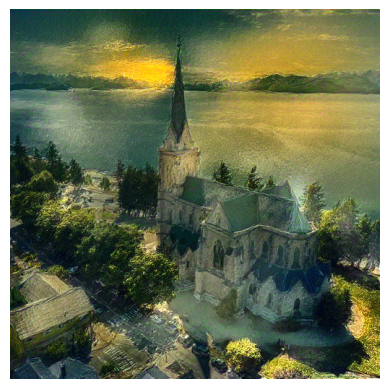

In [129]:
# hyperparameters 
epochs = 2000
alpha = 5
beta  = 1e3
# optimizer
optimizer = torch.optim.Adam([white_noise],lr=0.05)

for i in (t := trange(epochs)):

    # compute learning texture of style image
    white_to_style = [style_feature_extractor(white_noise)[f'conv{i}'] for i in range(1,6)]
    gram_white_to_style =  [GramMatrix(mat) for mat in white_to_style]

    cte = [torch.tensor(1/(4*(N_l[i]**2)*(M_l[i]**2))) for i in range(0,5)]
    loss_style = 0.0
    for i in range(0,5):
        loss_style += cte[i]*torch.nn.MSELoss(reduction='sum')(style_gram[i], gram_white_to_style[i])

    # compute reconstruct content image
    loss_content = torch.mean((content_feature_extractor(white_noise)['conv5'] - content_layers)**2)

    total_loss = alpha*loss_content + beta*loss_style
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    t.set_description(f'loss function = {total_loss}')

reconstructed_image = im_convert(white_noise)
reconstructed_image = Image.fromarray((reconstructed_image * 255).astype('uint8'))    
plt.imshow(reconstructed_image)
plt.axis('off')
plt.show()